Sentiment analysis of movie (IMDB) reviews using dataset provided by the ACL 2011 paper, 
see http://ai.stanford.edu/~amaas/data/sentiment/
This notebook uses neural net models

The plan is to compare a variety of hyperparameters, vectorization techniques, neural net based models:
* dense neural network with bag of words
* dense neural network with fixed size input and words mapped to integers
* LSTM
* CNN


### Table of Contents<a class="anchor" id="table"></a>
* [Load data](#load)
* [Train different architectures](#train)
    * [Train NN 50 - 10 - 1](#train1)
    * [Train NN 256 - 128 - 1](#train2)
    * [Train NN with K-Fold cross validation](#kfold)
    * [Train RNN](#rnn)
* [Optimize](#opti)
    * [Optimize on dropouts](#opti_d)
        * no dropout
        * low dropout on 1 layer
        * high dropout on 1 layer
        * low dropout on 2 layers
        * high dropout on 2 layers
        * [Observation](#opti_d_o)

In [3]:
!pip install wget

In [4]:
import numpy as np
import os
import os.path
import glob
import time
import string

import pandas as pd
import matplotlib as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.model_selection import KFold

In [6]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

Dataset directory exists, taking no action


In [0]:
def foundGPU():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('No GPU found')
    return False
  else: 
    print('Found GPU at: {}'.format(device_name))
    return True

In [8]:
# configuration
if foundGPU():
  SAMPLE_SIZE=12500
else:
  SAMPLE_SIZE=2000

BATCH_SIZE=64
TRAIN_TEST_RATIO=0.25
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

Found GPU at: /device:GPU:0


<a href='#table'>Back</a>
# Load data<a class="anchor" id="load"></a>

## Create a dense vector from reviews 

In [0]:
time_beginning_of_notebook = time.time()
SLICE = int(SAMPLE_SIZE / 2)
positive_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_file_list[:SLICE]

negative_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_file_list[:SLICE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

In [0]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_tokenized = [word_tokenize(s) for s in positive_strings]
negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [11]:
print(negative_tokenized[:100])

[['If', 'you', 'did', "n't", 'know', 'better', ',', 'you', 'would', 'believe', 'the', 'Christian', 'moral', 'majority', 'in', 'their', 'preachy', 'testimonial', 'of', 'the', 'sins', 'of', 'the', 'young', ',', 'their', 'questing', 'for', 'Satan', ',', 'and', 'that', 'Hell', 'was', 'just', 'brimming', 'with', 'Advanced', 'Dungeons', 'and', 'Dragons', 'fans', '.', 'None', 'of', 'these', 'items', 'bears', 'one', 'grain', 'of', 'truth', ',', 'folks', '.', 'This', 'work', 'does', 'nothing', 'but', 'give', 'the', 'Southern', 'Baptists', 'a', 'chance', 'to', 'take', 'a', 'breath', ',', 'while', 'the', 'movie', 'continues', 'to', 'spout', 'their', 'erroneous', 'and', 'alarmist', 'views', 'concerning', 'a', 'creative', 'and', 'original', 'gaming', 'system', '.', 'Tom', 'Hanks', 'contributes', 'a', 'stellar', 'performance', 'for', 'this', 'work', ',', 'but', 'even', 'that', 'was', "n't", 'enough', 'to', 'save', 'it', '.', 'It', "'s", 'crap', '.', 'It', "'s", 'beneath', 'crap', '.', 'It', 'is', 'i

In [0]:
from collections import Counter
import numpy as np

In [0]:
stop = stopwords.words('english') + list(string.punctuation) + ["''", '``', '...', "'s", "n't"]

total_counts = Counter()
all_reviews = positive_tokenized + negative_tokenized
for r in all_reviews:
    sig_words = [w.lower() for w in r if w.lower() not in stop]
    for word in sig_words:
        total_counts[word] += 1

In [0]:
vocab_size = 1000

vocab = total_counts.most_common(vocab_size)
vocab = [t[0] for t in vocab]


In [15]:
print(vocab)

['movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time', 'really', 'story', 'see', 'much', 'could', 'well', 'get', 'bad', 'also', 'first', 'great', 'people', 'made', 'make', 'way', 'movies', 'think', 'characters', 'watch', 'character', 'many', 'films', 'two', 'seen', 'best', 'show', 'never', 'little', 'acting', 'plot', 'life', 'know', 'love', 'ever', 'better', 'end', 'man', 'still', 'say', 'scene', "'ve", 'something', 'scenes', 'go', '--', 'back', "'m", 'watching', 'though', 'thing', 'years', 'real', 'actually', 'actors', 'funny', 'find', 'another', 'nothing', 'work', 'new', 'makes', 'lot', 'old', 'look', 'going', 'part', 'every', 'director', 'cast', 'us', 'got', 'things', "'re", 'quite', 'pretty', 'take', 'world', 'ca', 'young', 'want', 'around', 'fact', 'however', 'seems', 'enough', 'may', 'thought', 'right', 'give', 'original', 'big', 'horror', 'series', 'without', 'gets', 'long', 'saw', 'come', 'always', 'least', 'action', 'must', 'times', 'interesting', 'role', 'family', 

In [0]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [17]:
print("ID of 'movie' = {}".format(word2index['movie']))

ID of 'movie' = 0


In [0]:
def convert_to_bag(review):
    bag = np.zeros(vocab_size)
    for word in review:
        if word in vocab:
          i = word2index[word.lower()]
          bag[i]+=1
    return bag

In [0]:
test_bag = convert_to_bag(all_reviews[0])

In [0]:
all_reviews_encoded = [convert_to_bag(x) for x in all_reviews]

In [21]:
all_reviews_encoded[0].shape

(1000,)

In [0]:
import random

positive_labels = []
for i in range(len(positive_tokenized)):
    positive_labels.append('POSITIVE')
negative_labels = []
for i in range(len(negative_tokenized)):
    negative_labels.append('NEGATIVE')
   

In [0]:
labels = positive_labels + negative_labels

num_lables = []

for val in labels:
    if val == 'POSITIVE':
       num_lables.append(1)
    else:
       num_lables.append(0) 
    

In [0]:
reviews_and_labels = list(zip(all_reviews_encoded, num_lables))
random.shuffle(reviews_and_labels)
reviews, labels = zip(*reviews_and_labels)

In [0]:
labels = np.array(labels)

In [0]:
def saveTrainingMetrics(title):
  df = pd.DataFrame(results.history)
  df=df[df['val_acc']==df.val_acc.max()]
  df=df[df['acc']==df.acc.min()]

  df.reset_index(inplace=True)
    
  df["title"]=[title]
  df["sample_size"]=[SAMPLE_SIZE]
  df["batch_size"]=[BATCH_SIZE]
  df["train_test_ratio"]=[TRAIN_TEST_RATIO]
  df["training_set_size"]=[TRAINING_SET_SIZE]
  df["validation_set_size"]=[VALIDATION_SET_SIZE]
  df["vocab_size"]=[vocab_size]  
  df["nb_epochs"]=[EPOCHS]
  df.drop(labels="index",axis=1,inplace=True)
  print(df)
  df.to_csv(path_or_buf=df.iloc[0].title+".csv")

## Create a sparse matrix from reviews (where we keep the order of the words)

In [27]:
positive_strings[0]

'After watching the rather sloppy WW1 spy thriller, Madam Lili (1969)starring Julie Andrews on tv this afternoon, I suddenly thought I had seen a far superior WW1 spy thriller. All I could remember was that it was produced by Dino De Laurentis. It only took a short search on IMDB to find Fraulein Doktor. Once I recognised the title the memories came flooding back. It is, for its time, a reasonably well crafted story revolving around true events such as the death of Kitchener and the German offensives of 1918.It also has a female spy who is much more believable than Julie Andrews! As with other reviewers the first and strongest memory was of the well produced battle scenes and of men and horses in gas masks. If you have an interest in war films and particularly WW1 it is a film well worth seeing if you have the opportunity.'

In [0]:
### We need to found out why we need this code and possibly who has written this code
# reviews=[]
# for sentence in positive_strings:
#     reviews.append([sentence,1])
# for sentence in negative_strings:
#     reviews.append([sentence,0])
# random.shuffle(reviews)


In [0]:
# tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',\
#                                    lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

In [0]:
# len(reviews)

<a href='#table'>Back</a>
# Train models<a class="anchor" id="train"></a>
## Train NN 50 - 10 - 1 <a class="anchor" id="train1"></a>


In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [31]:
X_train

array([[3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [3., 1., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [32]:
model = keras.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(vocab_size, )))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                50050     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 50,571
Trainable params: 50,571
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [34]:
EPOCHS=20
results = model.fit(
 X_train, y_train,
 epochs=EPOCHS,
 validation_data=(X_test, y_test),
 batch_size=BATCH_SIZE
)

Train on 9375 samples, validate on 3125 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
9375/9375 [==============================] - 1s 126us/sample - loss: 0.5358 - acc: 0.7449 - val_loss: 0.3951 - val_acc: 0.8390
Epoch 2/20
9375/9375 [==============================] - 1s 83us/sample - loss: 0.3510 - acc: 0.8566 - val_loss: 0.3962 - val_acc: 0.8358
Epoch 3/20
9375/9375 [==============================] - 1s 85us/sample - loss: 0.3023 - acc: 0.8766 - val_loss: 0.3923 - val_acc: 0.8381
Epoch 4/20
9375/9375 [==============================] - 1s 86us/sample - loss: 0.2605 - acc: 0.8946 - val_loss: 0.4030 - val_acc: 0.8339
Epoch 5/20
9375/9375 [==============================] - 1s 85us/sample - loss: 0.2139 - acc: 0.9154 - val_loss: 0.4150 - val_acc: 0.8394
Epoch 6/20
9375/9375 [==============================] - 1s 83us/sample - loss: 0.1600 - acc: 0.9418 - val_loss: 0.4512 - val_acc: 0.8294
Epoch 7/20
9375/9375 [==============================] - 1s 83us/sample - loss: 0.

In [35]:
saveTrainingMetrics("Opti-NN-Train NN 50 - 10 - 1")

        acc      loss  val_acc  val_loss                         title  \
0  0.915413  0.213885  0.83936   0.41496  Opti-NN-Train NN 50 - 10 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  
0                 3125        1000         20  


## Train NN 256 - 128 - 1 <a class="anchor" id="train2"></a>

In [0]:
model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 289,281
Trainable params: 289,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [39]:
EPOCHS=5
results = model.fit(
 X_train, y_train,
 epochs=EPOCHS,
 validation_data=(X_test, y_test),
batch_size=BATCH_SIZE
)

Train on 9375 samples, validate on 3125 samples
Epoch 1/5
9375/9375 [==============================] - 1s 111us/sample - loss: 0.4580 - acc: 0.7935 - val_loss: 0.3759 - val_acc: 0.8374
Epoch 2/5
9375/9375 [==============================] - 1s 88us/sample - loss: 0.2756 - acc: 0.8869 - val_loss: 0.3817 - val_acc: 0.8333
Epoch 3/5
9375/9375 [==============================] - 1s 87us/sample - loss: 0.1619 - acc: 0.9428 - val_loss: 0.4394 - val_acc: 0.8259
Epoch 4/5
9375/9375 [==============================] - 1s 87us/sample - loss: 0.0557 - acc: 0.9863 - val_loss: 0.5886 - val_acc: 0.8250
Epoch 5/5
9375/9375 [==============================] - 1s 88us/sample - loss: 0.0130 - acc: 0.9978 - val_loss: 0.7423 - val_acc: 0.8291


In [40]:
results.history

{'acc': [0.79349333, 0.8869333, 0.9428267, 0.98634666, 0.99776],
 'loss': [0.4580307288233439,
  0.2755668417453766,
  0.16190532801946003,
  0.055740674928824105,
  0.01299528782894214],
 'val_acc': [0.83744, 0.83328, 0.82592, 0.82496, 0.82912],
 'val_loss': [0.3758724998950958,
  0.38167366922378543,
  0.43937484813690186,
  0.5885822653484345,
  0.7422854831886292]}

In [41]:
saveTrainingMetrics("Opti-NN-Train NN 256 - 128 - 1")

        acc      loss  val_acc  val_loss                           title  \
0  0.793493  0.458031  0.83744  0.375872  Opti-NN-Train NN 256 - 128 - 1   

   sample_size  batch_size  train_test_ratio  training_set_size  \
0        12500          64              0.25               9375   

   validation_set_size  vocab_size  nb_epochs  
0                 3125        1000          5  


## Train NN with K-Fold cross validation <a class="anchor" id="kfold"></a>

In [0]:
from keras.callbacks import History

def getBestResultsFrom(bestResults,results):
  if bestResults is None:
    return results
  
  bestResultsDf = pd.DataFrame(data=bestResults.history)
  bestResultsDf=bestResultsDf.sort_values(['val_acc'], ascending=False)
  resultsDf = pd.DataFrame(data=results.history)
  resultsDf=resultsDf.sort_values(['val_acc'], ascending=False)
  
  if bestResultsDf['val_acc'].iloc[0] > resultsDf['val_acc'].iloc[0]:    
    return bestResults
  
  if bestResultsDf['val_acc'].iloc[0] == resultsDf['val_acc'].iloc[0]:
    if bestResultsDf['acc'].iloc[0] < resultsDf['acc'].iloc[0]:
      return bestResults
    else:
      return results

  return results

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [166]:
train_data[0][0].shape

(1000,)

In [0]:
EPOCHS=5
SAMPLE_SIZE=len(X_train)
TRAIN_TEST_RATIO=(1/FOLDS)
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)
histories=[]

In [168]:
bestResults=None
for train_indices, test_indices in kfold.split(X_train,y=y_train):
    model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(vocab_size,)),
      layers.Dense(128, activation = "relu"),
      layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
      optimizer = "adam",
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
    )
    K_X_train = X_train[train_indices]
    K_y_train = y_train[train_indices]
    K_X_test = X_train[test_indices]
    K_y_test = y_train[test_indices]
    results=model.fit(
      K_X_train, K_y_train,
      epochs=EPOCHS,
      validation_data=(K_X_test, K_y_test),
      batch_size=BATCH_SIZE
    )
    histories.append(results.history)
    bestResults=getBestResultsFrom(bestResults,results)
    
results=bestResults

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 271us/sample - loss: 0.4866 - acc: 0.7749 - val_loss: 0.3835 - val_acc: 0.8294
Epoch 2/5
6250/6250 [==============================] - 1s 108us/sample - loss: 0.2752 - acc: 0.8890 - val_loss: 0.3845 - val_acc: 0.8314
Epoch 3/5
6250/6250 [==============================] - 1s 111us/sample - loss: 0.1607 - acc: 0.9419 - val_loss: 0.4438 - val_acc: 0.8256
Epoch 4/5
6250/6250 [==============================] - 1s 110us/sample - loss: 0.0568 - acc: 0.9853 - val_loss: 0.5771 - val_acc: 0.8320
Epoch 5/5
6250/6250 [==============================] - 1s 107us/sample - loss: 0.0150 - acc: 0.9976 - val_loss: 0.6757 - val_acc: 0.8285
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 274us/sample - loss: 0.4656 - acc: 0.7837 - val_loss: 0.3936 - val_acc: 0.8342
Epoch 2/5
6250/6250 [==============================] - 1s 107us/sample - loss: 0.2

In [169]:
saveTrainingMetrics("Opti-NN-Train NN with K-Fold cross validation")

       acc      loss  val_acc  val_loss  \
0  0.78368  0.465594  0.83424  0.393609   

                                           title  sample_size  batch_size  \
0  Opti-NN-Train NN with K-Fold cross validation         9375          64   

   train_test_ratio  training_set_size  validation_set_size  vocab_size  \
0          0.333333               6250                 3125        1000   

   nb_epochs  
0          5  


mean acc: 0.9981866876284281, mean val_acc: 0.8230399886767069


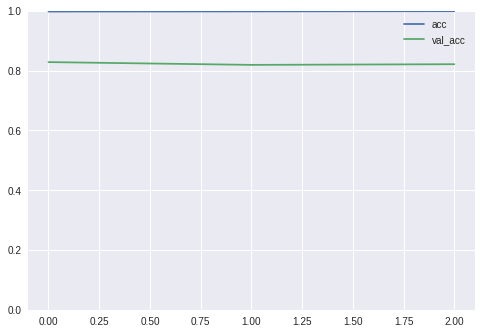

In [170]:
df = pd.DataFrame(data=histories)
for col in df.columns:
    df[col] =  df[col].apply(lambda x: x[-1])
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0,1])

means=df[["acc","val_acc"]].mean()
print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))

## Train RNN <a class="anchor" id="rnn"></a>

<a href='#table'>Back</a>
# OPTIMIZE<a class="anchor" id="opti"></a>

## Optimize on dropout<a class="anchor" id="opti_d"></a>

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [0]:
FOLDS=3
kfold = KFold(FOLDS, True, 1)

In [0]:
train_data = list(zip(X_train, y_train))

In [0]:
from pdb import set_trace

def getMeansFromResultsHistory(histories):
  df = pd.DataFrame(data=histories)
  for col in df.columns:
      df[col] =  df[col].apply(lambda x: x[-1])
  means=df[["acc","val_acc"]].mean()
  return means

def trainModelWithDropoutOn1Layer(epochs_nb=5,rate=0.0):
  EPOCHS=5
  SAMPLE_SIZE=len(X_train)
  TRAIN_TEST_RATIO=(1/FOLDS)
  TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
  VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

  histories=[]
  bestResults=None
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
        layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
        layers.Dropout(rate),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs=epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=BATCH_SIZE
      )
      histories.append(results.history)
      bestResults=getBestResultsFrom(bestResults,results)
  
  means=getMeansFromResultsHistory(histories)
  print(means) 
  return bestResults,means

def trainModelWithDropoutOn2Layers(epochs_nb=5,rate=0.0):
  EPOCHS=5
  SAMPLE_SIZE=len(X_train)
  TRAIN_TEST_RATIO=(1/FOLDS)
  TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
  VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

  histories=[]
  bestResults=None
  for train_indices, test_indices in kfold.split(X_train,y=y_train):
      model = keras.Sequential([
      layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
      layers.Dropout(rate),
      layers.Dense(128, activation = "relu"),
      layers.Dropout(rate),
      layers.Dense(1, activation = "sigmoid")
      ])
      model.compile(
       optimizer = "adam",
       loss = "binary_crossentropy",
       metrics = ["accuracy"]
      )
      K_X_train = X_train[train_indices]
      K_y_train = y_train[train_indices]
      K_X_test = X_train[test_indices]
      K_y_test = y_train[test_indices]
      results=model.fit(
          K_X_train, K_y_train,
          epochs=epochs_nb,
          validation_data=(K_X_test, K_y_test),
          batch_size=BATCH_SIZE
      )
      histories.append(results.history)
      bestResults=getBestResultsFrom(bestResults,results)
  
  means=getMeansFromResultsHistory(histories)
  print(means) 
  return bestResults,means

In [0]:
dropout_means=[]

### No dropout


In [176]:
rate=0.0
EPOCHS=5
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,0])
saveTrainingMetrics("Opti-NN-Optimise with K-folds - No dropouts")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 282us/sample - loss: 0.4726 - acc: 0.7798 - val_loss: 0.4149 - val_acc: 0.8317
Epoch 2/5
6250/6250 [==============================] - 1s 110us/sample - loss: 0.2659 - acc: 0.8978 - val_loss: 0.4349 - val_acc: 0.8230
Epoch 3/5
6250/6250 [==============================] - 1s 112us/sample - loss: 0.1515 - acc: 0.9458 - val_loss: 0.5081 - val_acc: 0.8186
Epoch 4/5
6250/6250 [==============================] - 1s 113us/sample - loss: 0.0524 - acc: 0.9861 - val_loss: 0.6425 - val_acc: 0.8182
Epoch 5/5
6250/6250 [==============================] - 1s 110us/sample - loss: 0.0105 - acc: 0.9995 - val_loss: 0.8161 - val_acc: 0.8182
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 288us/sample - loss: 0.4774 - acc: 0.7816 - val_loss: 0.3958 - val_acc: 0.8368
Epoch 2/5
6250/6250 [==============================] - 1s 111us/sample - loss: 0.2

### Low dropout on 1 layer

In [177]:
rate=0.2
EPOCHS=5
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 1 layer")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 298us/sample - loss: 0.4881 - acc: 0.7741 - val_loss: 0.4254 - val_acc: 0.8253
Epoch 2/5
6250/6250 [==============================] - 1s 113us/sample - loss: 0.2880 - acc: 0.8810 - val_loss: 0.4337 - val_acc: 0.8253
Epoch 3/5
6250/6250 [==============================] - 1s 113us/sample - loss: 0.1918 - acc: 0.9237 - val_loss: 0.4822 - val_acc: 0.8205
Epoch 4/5
6250/6250 [==============================] - 1s 113us/sample - loss: 0.0961 - acc: 0.9682 - val_loss: 0.5914 - val_acc: 0.8173
Epoch 5/5
6250/6250 [==============================] - 1s 112us/sample - loss: 0.0391 - acc: 0.9907 - val_loss: 0.7338 - val_acc: 0.8138
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 303us/sample - loss: 0.4845 - acc: 0.7715 - val_loss: 0.4121 - val_acc: 0.8250
Epoch 2/5
6250/6250 [==============================] - 1s 116us/sample - loss: 0.3

### High dropout on 1 layer


In [178]:
rate=0.4
EPOCHS=5
results,means=trainModelWithDropoutOn1Layer(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 1 layer")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 311us/sample - loss: 0.5012 - acc: 0.7621 - val_loss: 0.4083 - val_acc: 0.8314
Epoch 2/5
6250/6250 [==============================] - 1s 115us/sample - loss: 0.3219 - acc: 0.8685 - val_loss: 0.4044 - val_acc: 0.8320
Epoch 3/5
6250/6250 [==============================] - 1s 116us/sample - loss: 0.2392 - acc: 0.9048 - val_loss: 0.4429 - val_acc: 0.8240
Epoch 4/5
6250/6250 [==============================] - 1s 115us/sample - loss: 0.1547 - acc: 0.9443 - val_loss: 0.4940 - val_acc: 0.8262
Epoch 5/5
6250/6250 [==============================] - 1s 113us/sample - loss: 0.0984 - acc: 0.9678 - val_loss: 0.5876 - val_acc: 0.8218
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 317us/sample - loss: 0.5068 - acc: 0.7587 - val_loss: 0.3980 - val_acc: 0.8371
Epoch 2/5
6250/6250 [==============================] - 1s 115us/sample - loss: 0.3

### Low dropout on 2 layers

In [179]:
rate=0.2
EPOCHS=5
results,means=trainModelWithDropoutOn2Layers(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
saveTrainingMetrics("Opti-NN-Optimise with K-folds - Low dropout on 2 layers")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 329us/sample - loss: 0.4964 - acc: 0.7581 - val_loss: 0.4180 - val_acc: 0.8218
Epoch 2/5
6250/6250 [==============================] - 1s 117us/sample - loss: 0.2990 - acc: 0.8789 - val_loss: 0.4121 - val_acc: 0.8282
Epoch 3/5
6250/6250 [==============================] - 1s 115us/sample - loss: 0.1995 - acc: 0.9251 - val_loss: 0.4788 - val_acc: 0.8192
Epoch 4/5
6250/6250 [==============================] - 1s 119us/sample - loss: 0.1124 - acc: 0.9595 - val_loss: 0.5576 - val_acc: 0.8157
Epoch 5/5
6250/6250 [==============================] - 1s 119us/sample - loss: 0.0495 - acc: 0.9866 - val_loss: 0.6750 - val_acc: 0.8214
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 336us/sample - loss: 0.5030 - acc: 0.7589 - val_loss: 0.3938 - val_acc: 0.8397
Epoch 2/5
6250/6250 [==============================] - 1s 118us/sample - loss: 0.3

### High dropout on 2 layers


In [180]:
rate=0.4
EPOCHS=5
results,means=trainModelWithDropoutOn2Layers(epochs_nb=EPOCHS,rate=rate)
dropout_means.append([means["acc"],means["val_acc"], rate,1])
saveTrainingMetrics("Opti-NN-Optimise with K-folds - High dropout on 2 layers")

Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 344us/sample - loss: 0.5342 - acc: 0.7275 - val_loss: 0.4105 - val_acc: 0.8259
Epoch 2/5
6250/6250 [==============================] - 1s 120us/sample - loss: 0.3497 - acc: 0.8603 - val_loss: 0.4044 - val_acc: 0.8237
Epoch 3/5
6250/6250 [==============================] - 1s 122us/sample - loss: 0.2640 - acc: 0.8901 - val_loss: 0.4331 - val_acc: 0.8218
Epoch 4/5
6250/6250 [==============================] - 1s 120us/sample - loss: 0.1929 - acc: 0.9243 - val_loss: 0.4897 - val_acc: 0.8208
Epoch 5/5
6250/6250 [==============================] - 1s 120us/sample - loss: 0.1250 - acc: 0.9536 - val_loss: 0.5334 - val_acc: 0.8166
Train on 6250 samples, validate on 3125 samples
Epoch 1/5
6250/6250 [==============================] - 2s 350us/sample - loss: 0.5480 - acc: 0.7168 - val_loss: 0.4054 - val_acc: 0.8269
Epoch 2/5
6250/6250 [==============================] - 1s 116us/sample - loss: 0.3

Plot results

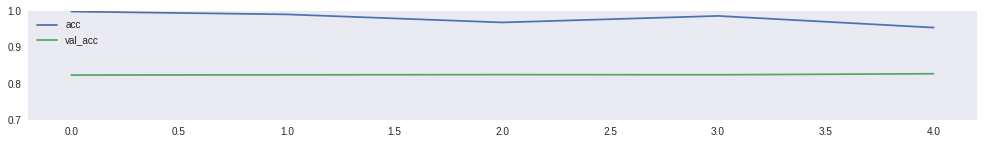

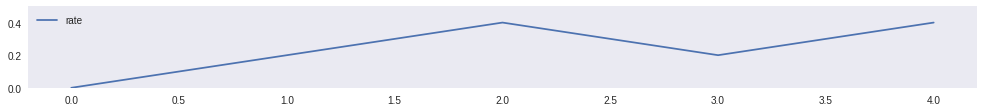

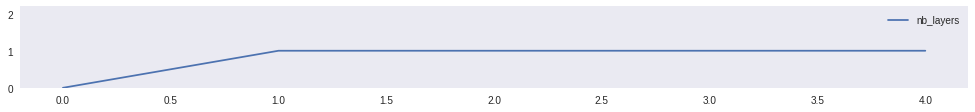

In [181]:
df = pd.DataFrame(data=dropout_means,columns=['acc','val_acc','rate','nb_layers'])
plt.rcParams["figure.figsize"] = [17,2]
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0.7,1])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["rate"]].plot()
plot.set_ylim([0,0.5])
plot.grid()

plt.rcParams["figure.figsize"] = [17,1.5]
plot=df[["nb_layers"]].plot()
plot.set_ylim([0,2.2])
plot.grid()

In [182]:
dropout_means

[[0.9986666639645895, 0.8234666585922241, 0.0, 0],
 [0.9908799727757772, 0.8240000009536743, 0.2, 1],
 [0.9686400095621744, 0.8246399958928426, 0.4, 1],
 [0.9866133332252502, 0.8242133259773254, 0.2, 1],
 [0.9544533292452494, 0.8270933429400126, 0.4, 1]]

### Observation<a class="anchor" id="opti_d_o"></a>
we have similar results, but got a higher test accuracy with low dropout on all layers and also less overfit (training and test accuracies are closer)